# Spotify Popularity Classification Pipeline


This notebook includes **classification** pipeline for predicting song popularity:
Predict if a song is popular (popularity >= 50)


In [1]:
import matplotlib as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('df_transformed_features_track2.pkl')
df

,danceability,energy,mode,valence,tempo,duration_ms,playlist_count,edm,latin,pop,...,instrumentalness_boxcox,liveness_boxcox,duration_ms_boxcox,playlist_count_boxcox,dance_energy,valence_tempo,beat_density,energy_loudness_ratio,rhythmic_stability,track_popularity
1,0.582,0.704,1,0.698,150.863,197286,1,0,0,0,...,-38.333297,-1.648104,49.828276,0.00001,0.409728,105.302374,3.027658,0.355574,0.6400,15
2,0.303,0.880,1,0.404,135.225,373512,1,0,0,0,...,-7.167531,-1.102976,57.084929,0.00001,0.266640,54.630900,2.368839,0.503639,0.3535,28
3,0.659,0.794,0,0.852,128.041,228565,1,0,0,1,...,-2.440969,-1.184368,51.422481,0.00001,0.523246,109.090932,2.489981,0.419282,0.7555,24
4,0.662,0.838,1,0.496,129.884,236308,1,0,0,1,...,-14.894270,-2.672622,51.789746,0.00001,0.554756,64.422464,2.507910,0.421556,0.5790,38
5,0.836,0.799,0,0.772,94.033,217653,1,0,1,0,...,-38.333297,-2.620436,50.887497,0.00001,0.667964,72.593476,1.847861,0.482006,0.8040,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28351,0.744,0.715,1,0.340,154.962,179773,1,0,0,0,...,-38.333297,-2.621744,48.844508,0.00001,0.531960,52.687080,3.172557,0.364700,0.5420,72
28352,0.832,0.666,0,0.810,109.536,223890,1,0,0,0,...,-38.333297,-2.918068,51.195855,0.00001,0.554112,88.724160,2.139548,0.374507,0.8210,36
28353,0.963,0.603,1,0.647,129.990,260240,1,0,0,1,...,-34.818242,-1.637521,52.866703,0.00001,0.580689,84.103530,2.458826,0.304945,0.8050,49
28354,0.458,0.540,0,0.657,142.218,191205,1,0,0,0,...,-16.728457,-2.354351,49.494962,0.00001,0.247320,93.437226,2.873383,0.268770,0.5575,40


A complete pipeline to train, tune, validate, and evaluate multiple classification models using GridSearchCV.

In [3]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier 
from sklearn.svm import SVC
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
#  binarize target

X =  df.drop(columns=[ 'track_popularity'])
y = (df["track_popularity"] >= 50).astype(int)

In [5]:
# 🔀 Split dataset: 70% train / 15% val / 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val)

In [6]:
# 📏 Evaluation function for classification
def classificationMetrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred), 3),
        "Recall": round(recall_score(y_true, y_pred), 3),
        "F1": round(f1_score(y_true, y_pred), 3),
        "ROC AUC": round(roc_auc_score(y_true, y_proba), 3)
    }

In [7]:
# 🔧 Hyperparameter grids
param_grids = {
    "Decision Tree": {
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5]
    },
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 5],
        "model__max_features": ['sqrt', 'log2']
    },
    "AdaBoost": {
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.1, 1.0]
    },
    "GBM": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.3],
        "model__max_depth": [3, 5]
    },
    "SVC": {
        "model__kernel": ['rbf', 'linear'],
        "model__C": [1, 10],
        "model__probability": [True]
    },
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.3],
        "model__max_depth": [3, 5]
    }
}

In [8]:
# 📦 Base classifiers
model_defs = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [10]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

results_df = pd.DataFrame()
best_models = {}

for name, model in model_defs.items():
    print(f"🔍 GridSearchCV for: {name}")

    # Cas spécial pour Random Forest avec SMOTE + class_weight
    if name == "Random Forest":
        pipeline = ImbPipeline([
            ("smote", SMOTE()),  # Peut être désactivé dans le param_grid
            ("scaler", StandardScaler()),
            ("model", RandomForestClassifier(random_state=42))
        ])
        param_grid = {
            "smote": [None, SMOTE()],
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__class_weight": [None, "balanced"]
        }
    else:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        param_grid = param_grids[name]

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val)
    y_val_proba = best_model.predict_proba(X_val)[:, 1]

    metrics = classificationMetrics(y_val, y_val_pred, y_val_proba)
    row = pd.DataFrame([{**{"Model": name}, **metrics}])
    results_df = pd.concat([results_df, row], ignore_index=True)
    best_models[name] = best_model

🔍 GridSearchCV for: Decision Tree
Fitting 3 folds for each of 6 candidates, totalling 18 fits
🔍 GridSearchCV for: Random Forest
Fitting 3 folds for each of 16 candidates, totalling 48 fits
🔍 GridSearchCV for: AdaBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔍 GridSearchCV for: GBM
Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 GridSearchCV for: SVC
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔍 GridSearchCV for: XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits


## 🔍 GridSearchCV Summary Block
This block displays the best cross-validation R² score, the best hyperparameters and a plot of mean test scores

### 🔍 Best Cross-Validation R² for **XGBoost**: `0.5516`

**Best Hyperparameters:** `{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}`

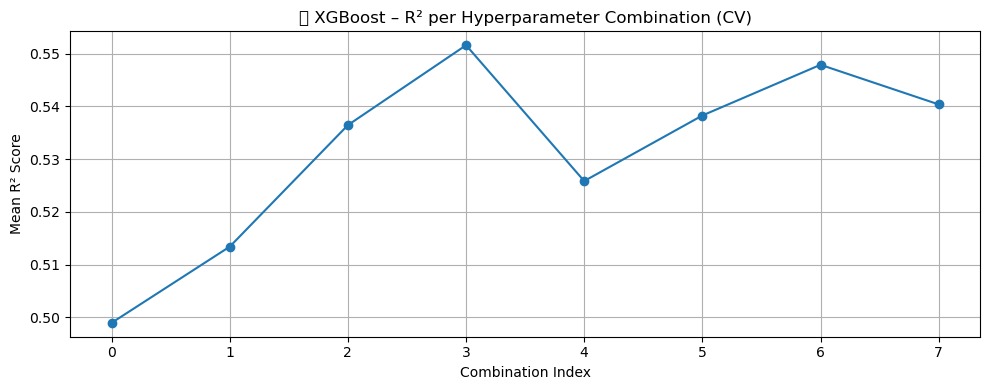

📁 GridSearchCV results saved: gridsearch_results_xgboost.csv


In [11]:
# 📋 GridSearch Summary for current model
best_score = grid.best_score_
best_params = grid.best_params_

from IPython.display import display, Markdown
display(Markdown(f"### 🔍 Best Cross-Validation R² for **{name}**: `{round(best_score, 4)}`"))
display(Markdown(f"**Best Hyperparameters:** `{best_params}`"))

# 📊 Plot all CV mean scores
cv_results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(10, 4))
plt.plot(cv_results['mean_test_score'], marker='o')
plt.title(f"📈 {name} – R² per Hyperparameter Combination (CV)")
plt.xlabel("Combination Index")
plt.ylabel("Mean R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 💾 Export GridSearch results (optional)
cv_results.to_csv(f"gridsearch_results_{name.replace(' ', '_').lower()}.csv", index=False)
print(f"📁 GridSearchCV results saved: gridsearch_results_{name.replace(' ', '_').lower()}.csv")

In [12]:
# 📊 Show validation results
results_df.sort_values(by="F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC AUC
1,Random Forest,0.694,0.591,0.625,0.607,0.748
4,SVC,0.704,0.646,0.486,0.554,0.735
5,XGBoost,0.706,0.661,0.460,0.543,0.754
3,GBM,0.699,0.648,0.451,0.532,0.747
0,Decision Tree,0.632,0.515,0.510,0.512,0.608
2,AdaBoost,0.674,0.610,0.386,0.473,0.715


In [13]:
# 🏆 Retrain best model on train+val and test
best_name = results_df.sort_values(by="F1", ascending=False).iloc[0]["Model"]
final_model = best_models[best_name]
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
final_metrics = classificationMetrics(y_test, y_test_pred, y_test_proba)
print(f"\n✅ Final test performance for {best_name}:")
print(final_metrics)


✅ Final test performance for Random Forest:
{'Accuracy': 0.691, 'Precision': 0.586, 'Recall': 0.626, 'F1': 0.605, 'ROC AUC': 0.752}


In [14]:
# 💾 Export results
results_df.to_csv("classification_model_comparison.csv", index=False)
print("✅ Results exported to classification_model_comparison.csv")

✅ Results exported to classification_model_comparison.csv


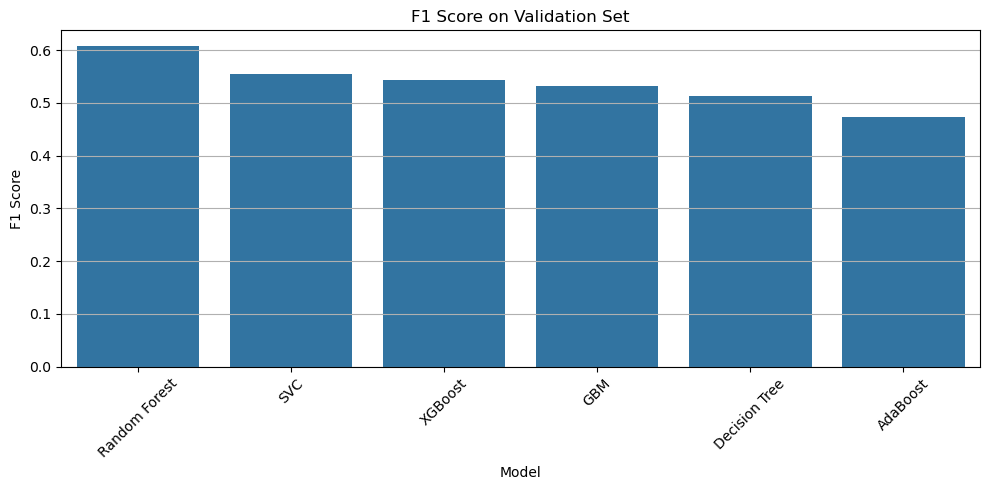

In [15]:
# 📈 Barplot of F1 scores on validation set
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.sort_values(by="F1", ascending=False), x="Model", y="F1")
plt.title("F1 Score on Validation Set")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

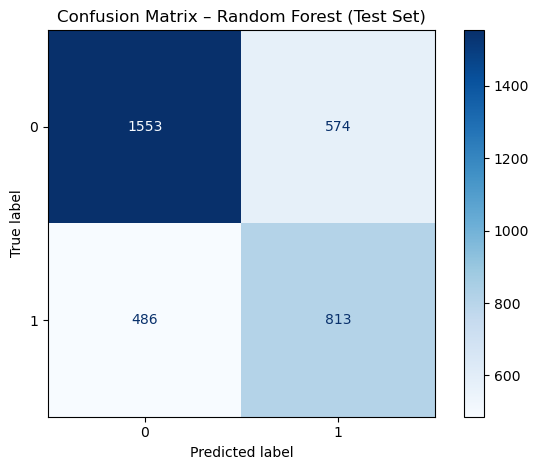

In [16]:
# 📊 Confusion matrix for test set
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix – {best_name} (Test Set)")
plt.grid(False)
plt.tight_layout()
plt.show()

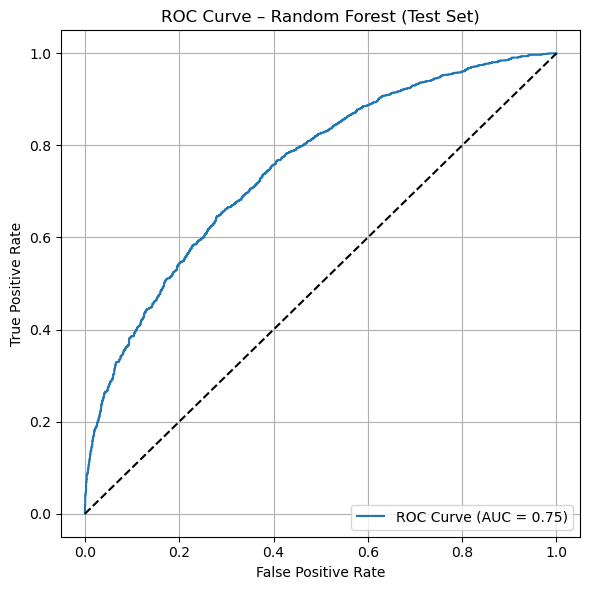

In [17]:
# 📈 ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {best_name} (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# 📄 Classification report export
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report_test.csv")
print("✅ Classification report exported to classification_report_test.csv")

✅ Classification report exported to classification_report_test.csv



📊 Confusion Matrix – Decision Tree


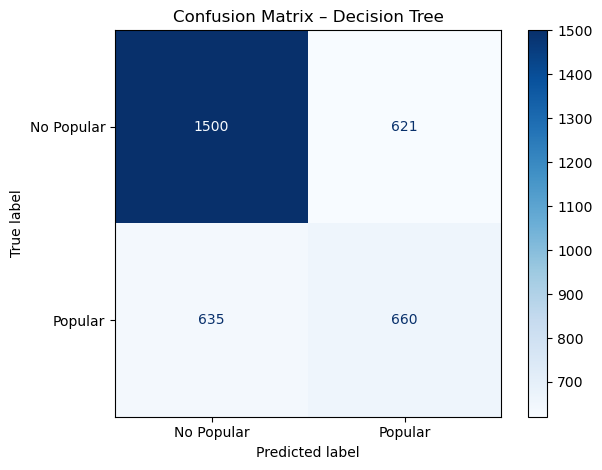


📊 Confusion Matrix – Random Forest


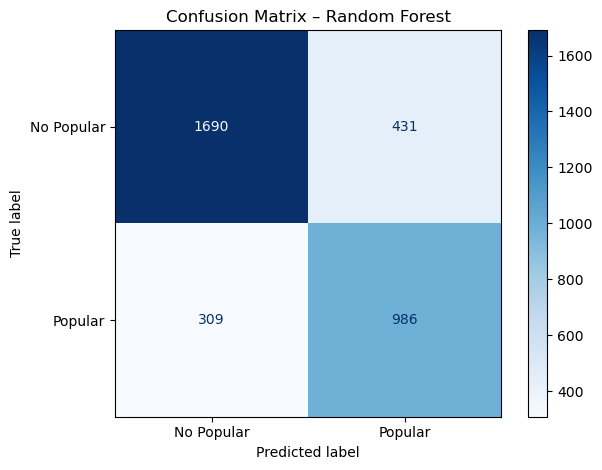


📊 Confusion Matrix – AdaBoost


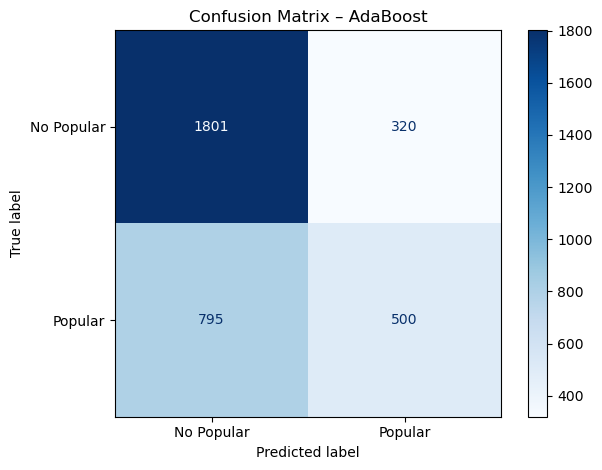


📊 Confusion Matrix – GBM


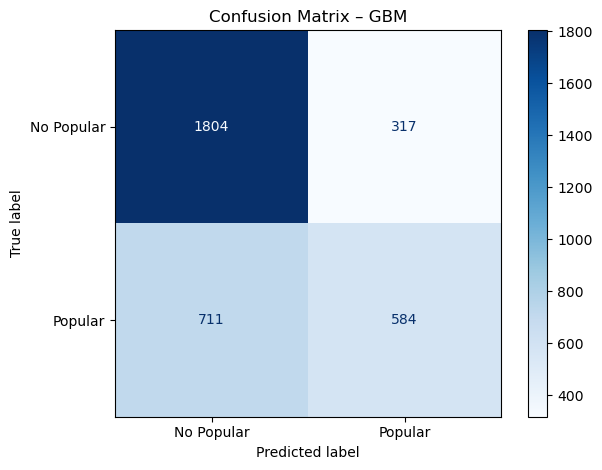


📊 Confusion Matrix – SVC


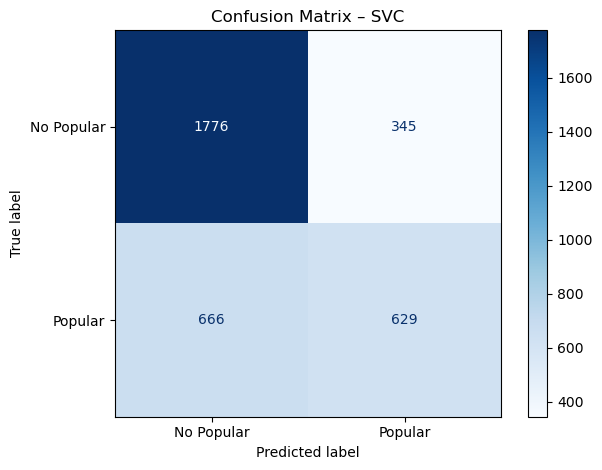


📊 Confusion Matrix – XGBoost


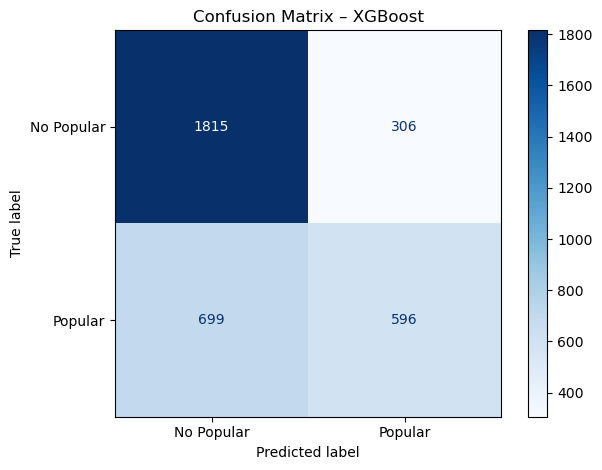

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔲 Show confusion matrices for each best model
for name, model in best_models.items():
    print(f"\n📊 Confusion Matrix – {name}")
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val,
                                          cmap="Blues",
                                          display_labels=["No Popular", "Popular"])
    plt.title(f"Confusion Matrix – {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


📈 ROC & PR Curves – Decision Tree


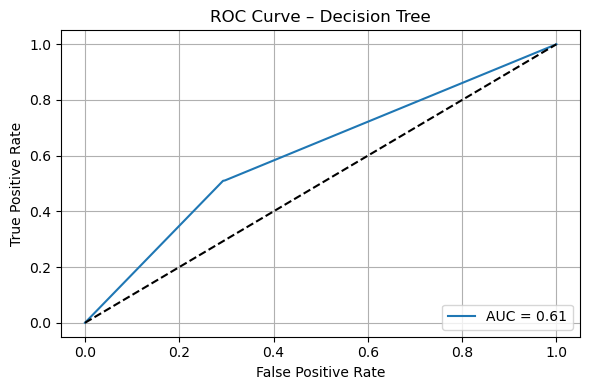

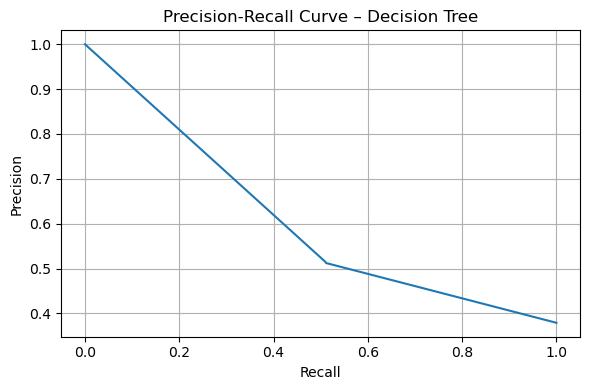


📈 ROC & PR Curves – Random Forest


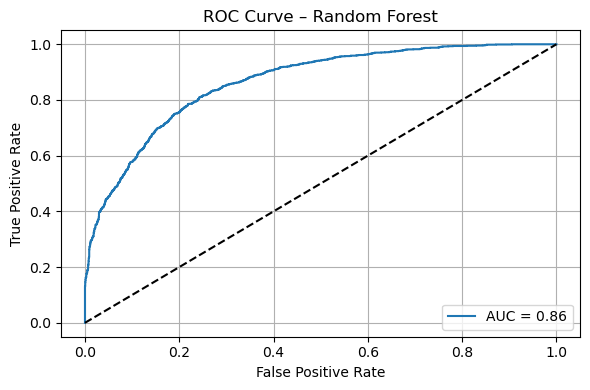

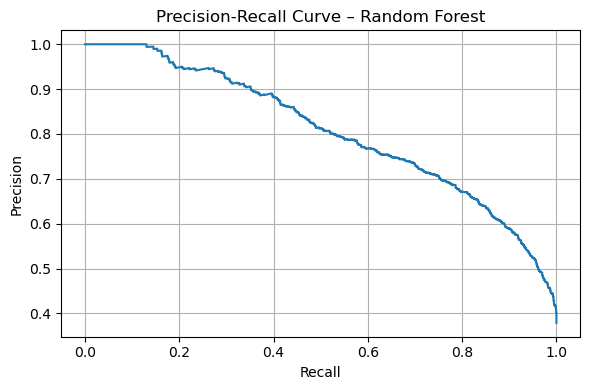


📈 ROC & PR Curves – AdaBoost


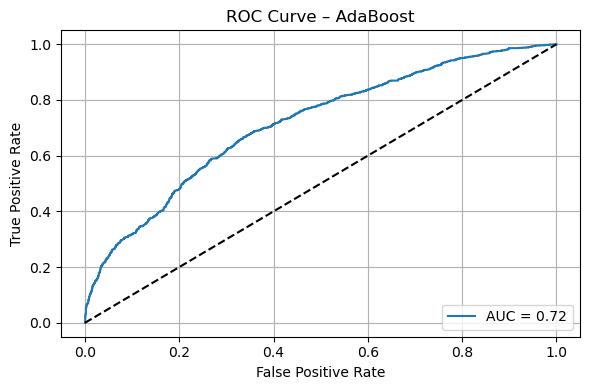

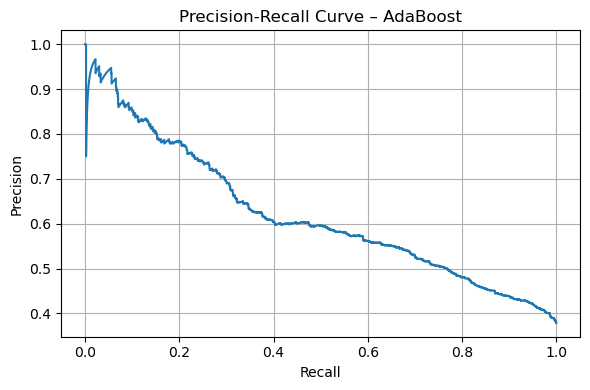


📈 ROC & PR Curves – GBM


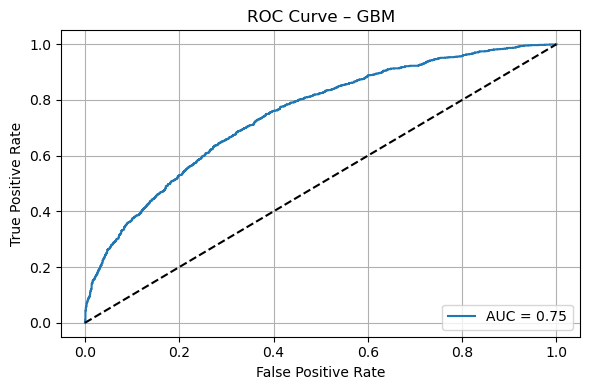

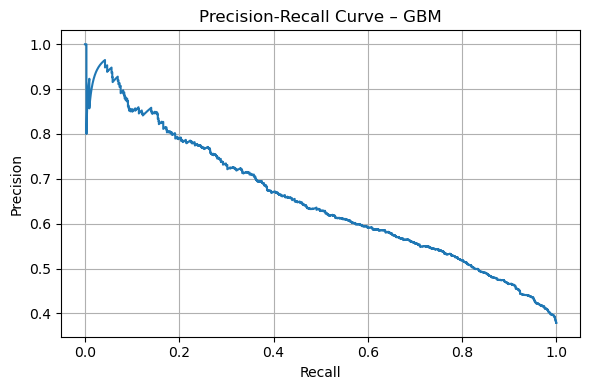


📈 ROC & PR Curves – SVC


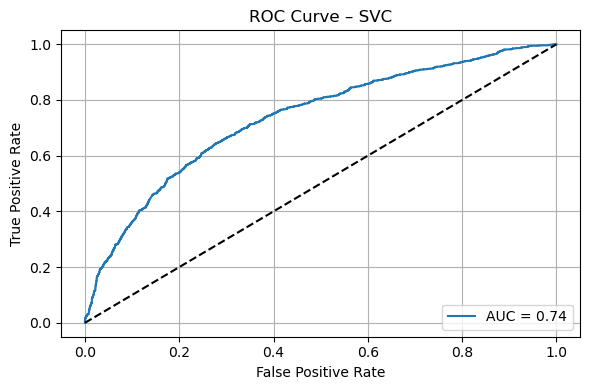

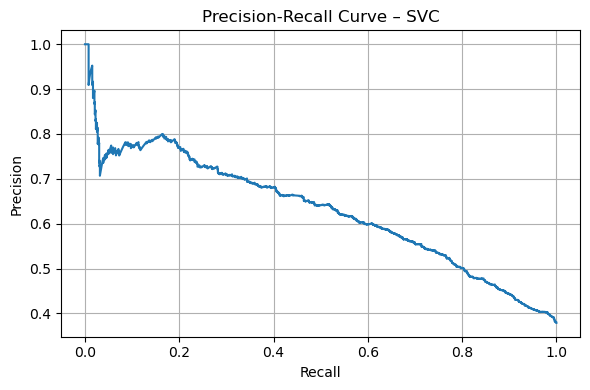


📈 ROC & PR Curves – XGBoost


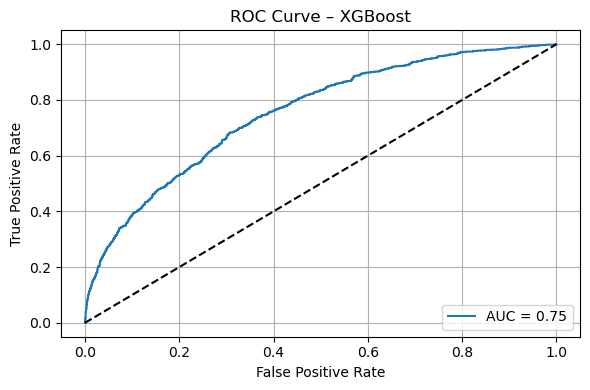

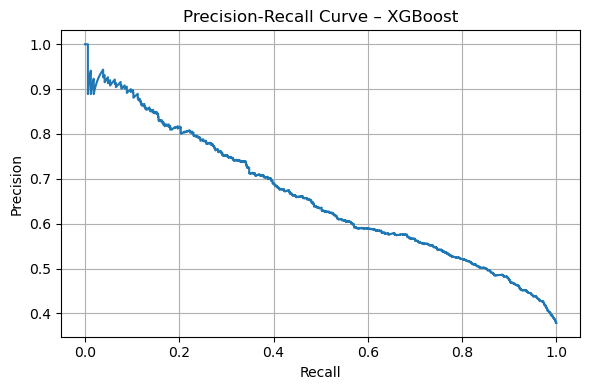

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# 📈 ROC and PR curves for all best models
for name, model in best_models.items():
    print(f"\n📈 ROC & PR Curves – {name}")
    y_scores = model.predict_proba(X_val)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Confusion Matrices

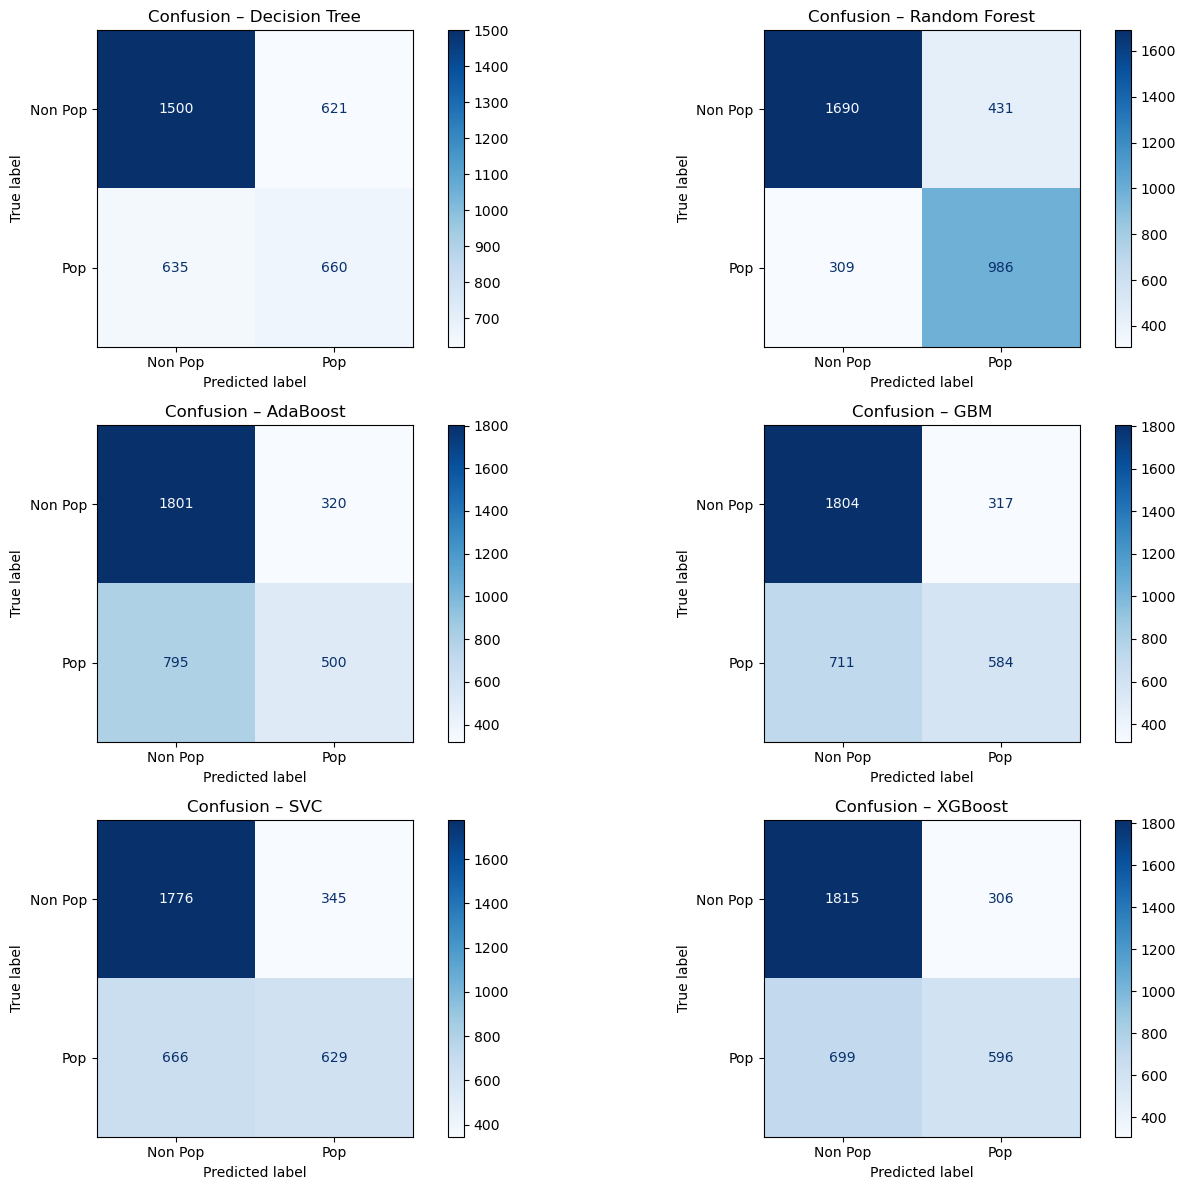

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔲 2 confusion matrices per row
models_list = list(best_models.items())
rows = len(models_list) // 2 + len(models_list) % 2
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(14, 4 * rows))

for i, (name, model) in enumerate(models_list):
    r, c = divmod(i, 2)
    ax = axes[r, c] if rows > 1 else axes[c]
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap="Blues",
                                          display_labels=["Non Pop", "Pop"], ax=ax)
    ax.set_title(f"Confusion – {name}")
    ax.grid(False)

# Hide empty subplot if odd
if len(models_list) % 2 != 0:
    axes[-1, -1].axis('off') if rows > 1 else axes[-1].axis('off')

plt.tight_layout()
plt.show()

# ROC & Precision-Recall Curves

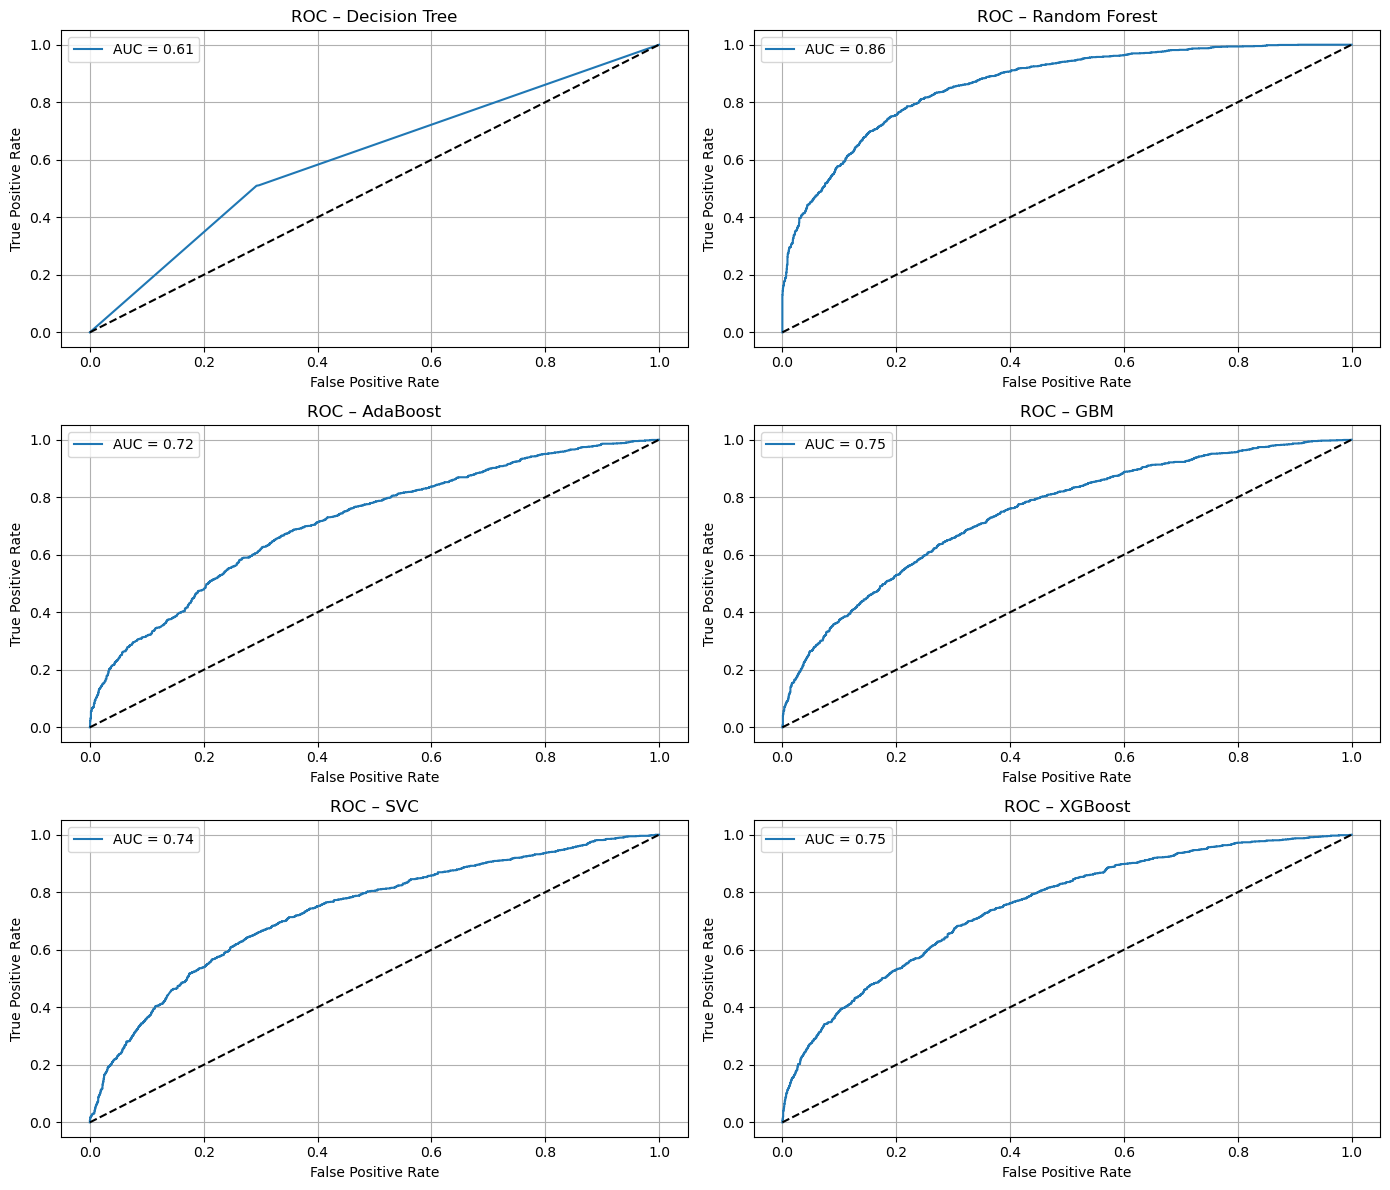

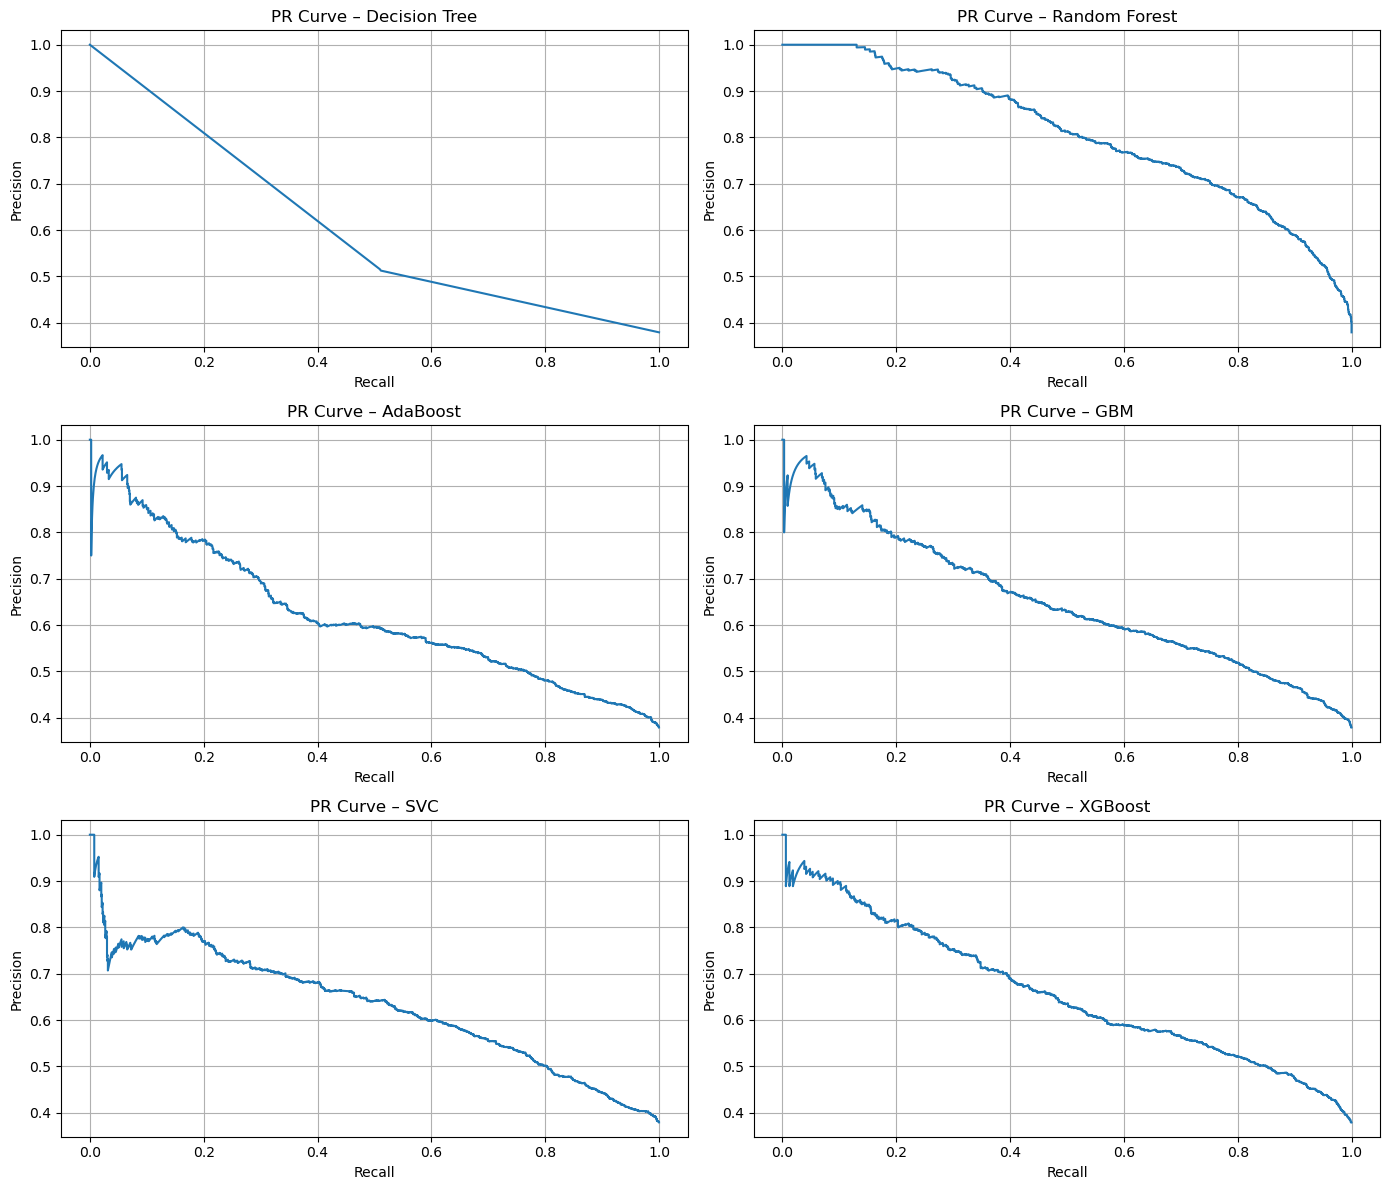

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

models_list = list(best_models.items())
rows = len(models_list) // 2 + len(models_list) % 2

# ROC Curves
fig, axes = plt.subplots(rows, 2, figsize=(14, 4 * rows))
for i, (name, model) in enumerate(models_list):
    r, c = divmod(i, 2)
    ax = axes[r, c] if rows > 1 else axes[c]
    y_scores = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f"ROC – {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.grid(True)

if len(models_list) % 2 != 0:
    axes[-1, -1].axis('off') if rows > 1 else axes[-1].axis('off')

plt.tight_layout()
plt.show()

# PR Curves
fig, axes = plt.subplots(rows, 2, figsize=(14, 4 * rows))
for i, (name, model) in enumerate(models_list):
    r, c = divmod(i, 2)
    ax = axes[r, c] if rows > 1 else axes[c]
    y_scores = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    ax.plot(recall, precision)
    ax.set_title(f"PR Curve – {name}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True)

if len(models_list) % 2 != 0:
    axes[-1, -1].axis('off') if rows > 1 else axes[-1].axis('off')

plt.tight_layout()
plt.show()

One combined plot per model with both ROC and PR curves.

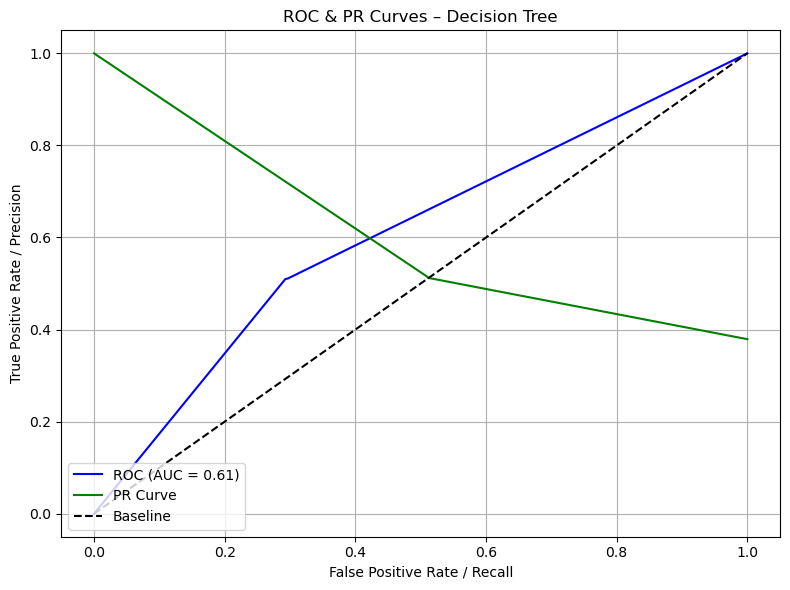

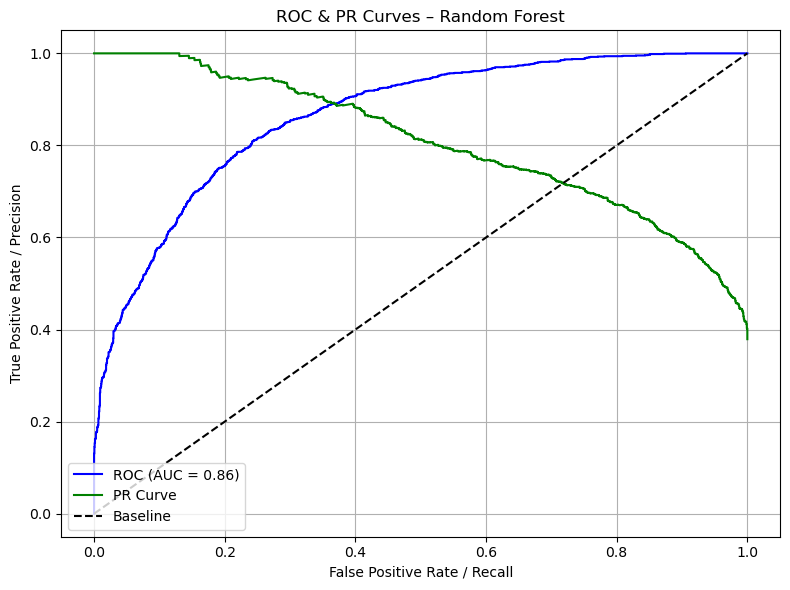

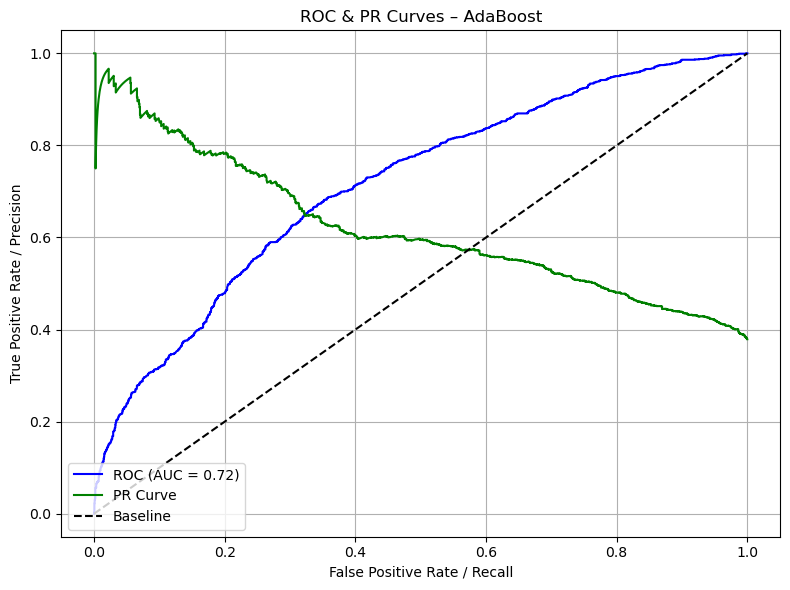

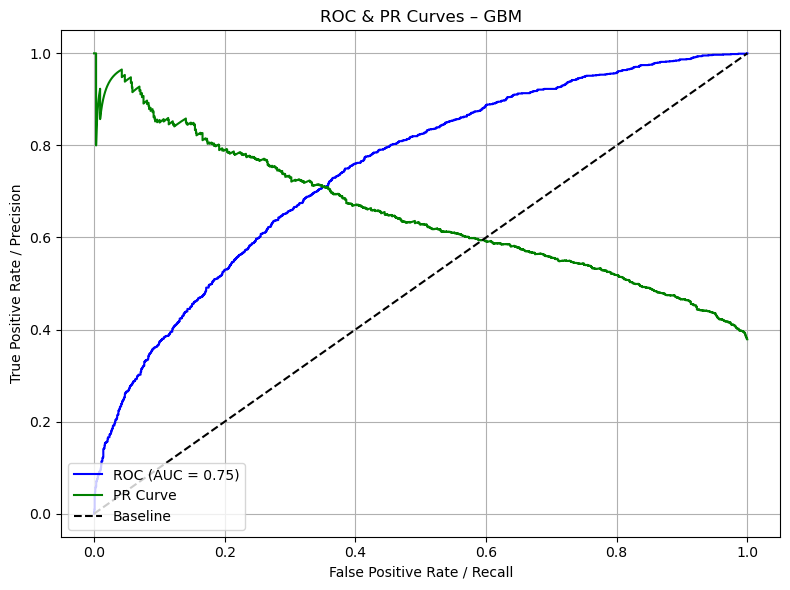

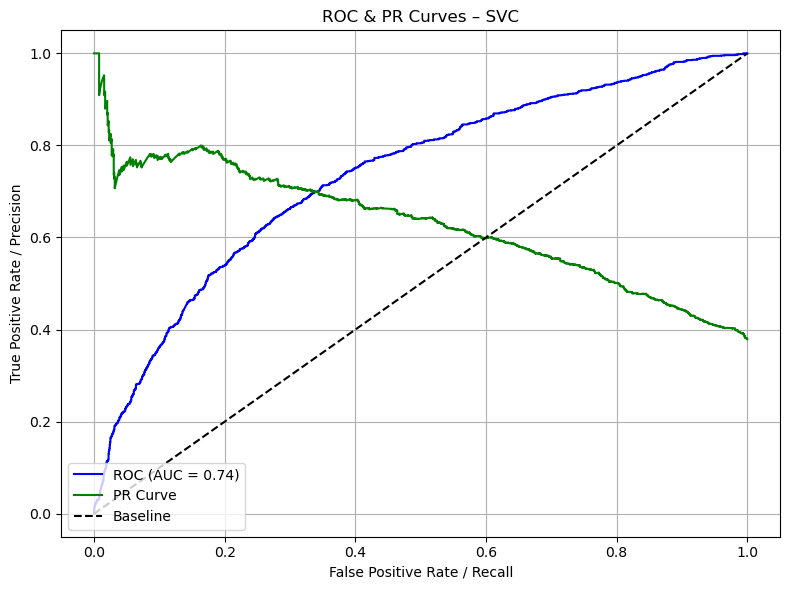

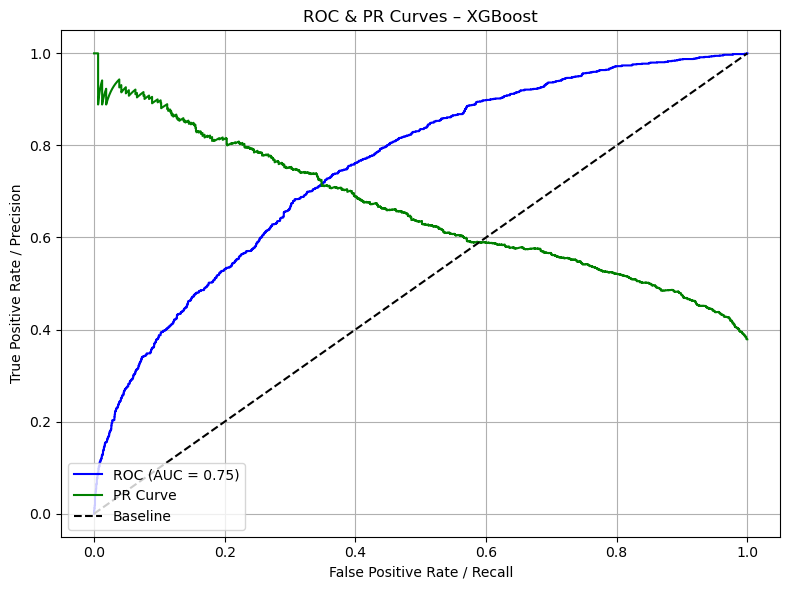

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# 📈 ROC + PR curves on the same plot for each model
for name, model in best_models.items():
    y_scores = model.predict_proba(X_val)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    # PR
    precision, recall, _ = precision_recall_curve(y_val, y_scores)

    # Combined plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="blue")
    plt.plot(recall, precision, label="PR Curve", color="green")
    plt.plot([0, 1], [0, 1], "k--", label="Baseline")
    plt.xlabel("False Positive Rate / Recall")
    plt.ylabel("True Positive Rate / Precision")
    plt.title(f"ROC & PR Curves – {name}")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

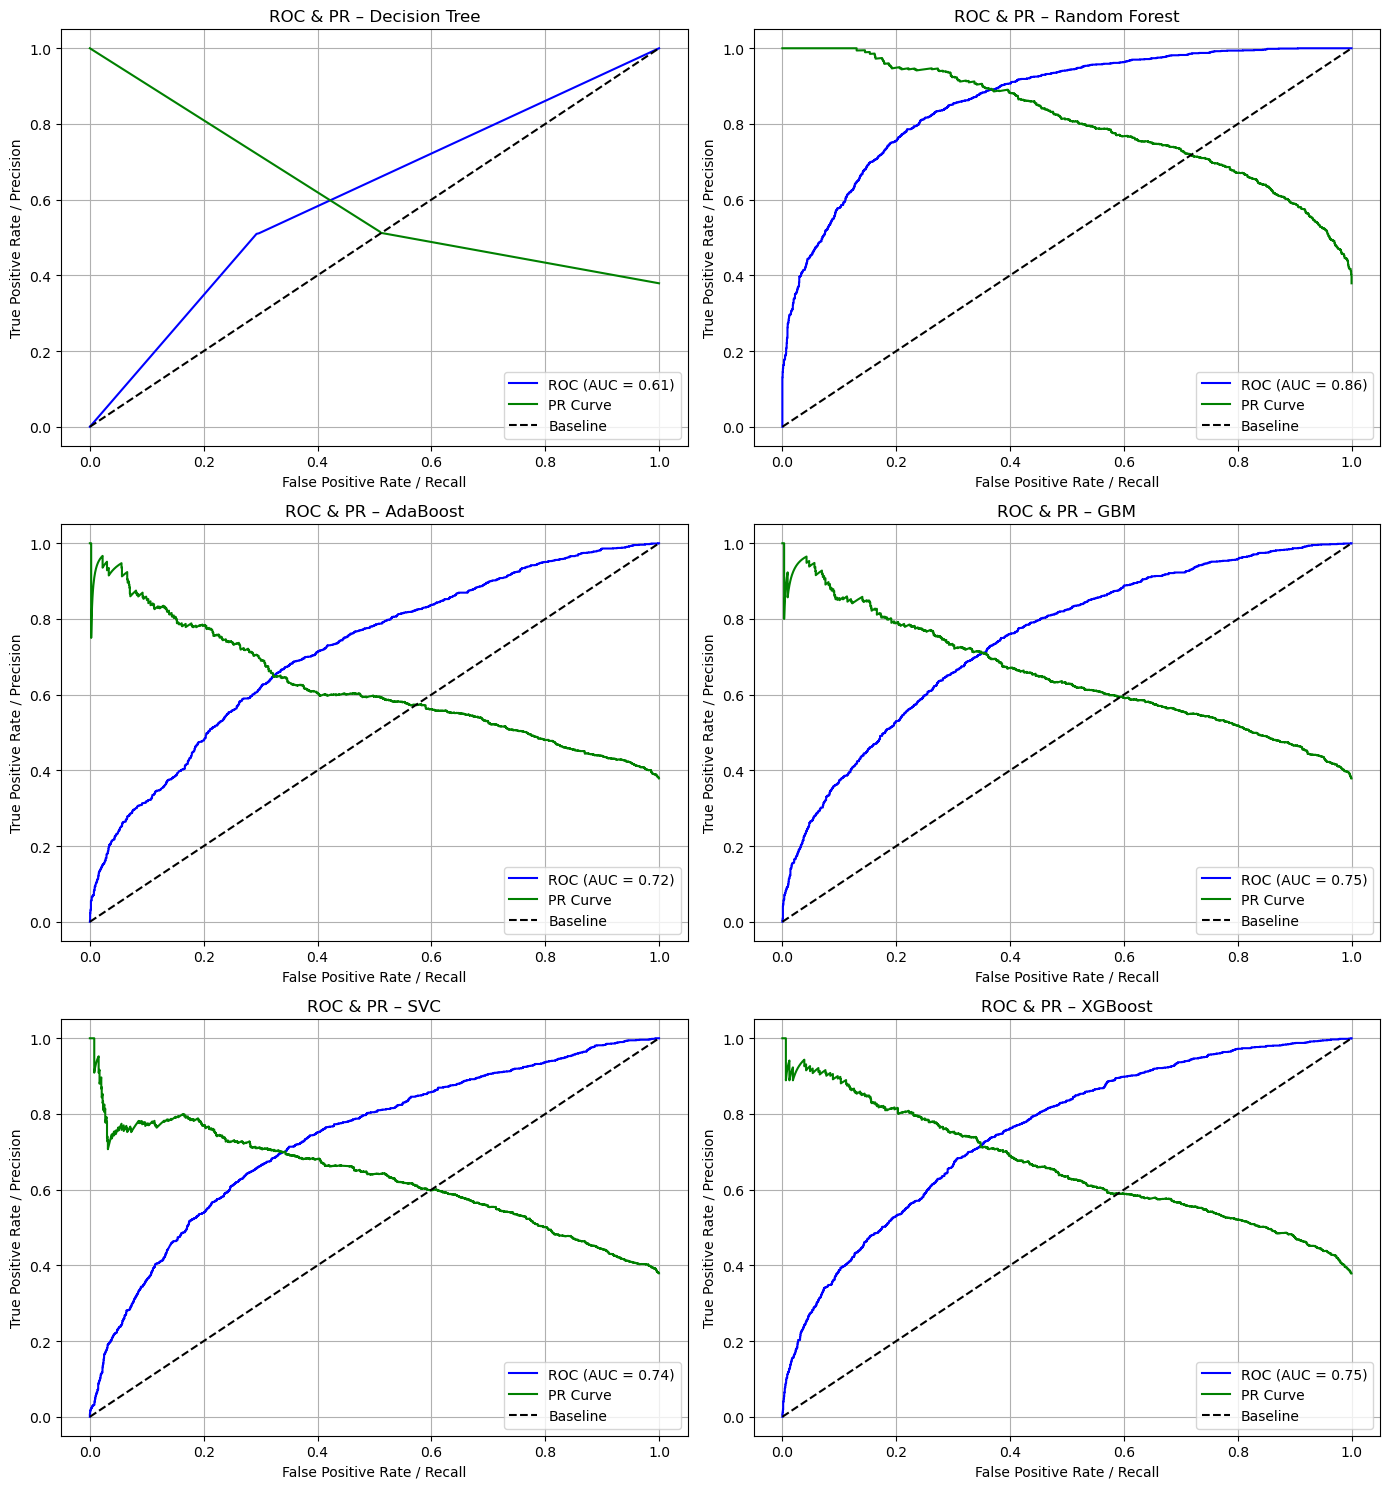

In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

models_list = list(best_models.items())
rows = len(models_list) // 2 + len(models_list) % 2
fig, axes = plt.subplots(rows, 2, figsize=(14, 5 * rows))

for i, (name, model) in enumerate(models_list):
    r, c = divmod(i, 2)
    ax = axes[r, c] if rows > 1 else axes[c]
    y_scores = model.predict_proba(X_val)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    # PR
    precision, recall, _ = precision_recall_curve(y_val, y_scores)

    ax.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="blue")
    ax.plot(recall, precision, label="PR Curve", color="green")
    ax.plot([0, 1], [0, 1], 'k--', label="Baseline")
    ax.set_title(f"ROC & PR – {name}")
    ax.set_xlabel("False Positive Rate / Recall")
    ax.set_ylabel("True Positive Rate / Precision")
    ax.legend()
    ax.grid(True)

# Hide empty plot if odd number of models
if len(models_list) % 2 != 0:
    axes[-1, -1].axis('off') if rows > 1 else axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Final Model Scores Summary

,Model,Accuracy,Precision,Recall,F1,ROC AUC
1,Random Forest,0.694,0.591,0.625,0.607,0.748
4,SVC,0.704,0.646,0.486,0.554,0.735
5,XGBoost,0.706,0.661,0.460,0.543,0.754
3,GBM,0.699,0.648,0.451,0.532,0.747
0,Decision Tree,0.632,0.515,0.510,0.512,0.608
2,AdaBoost,0.674,0.610,0.386,0.473,0.715


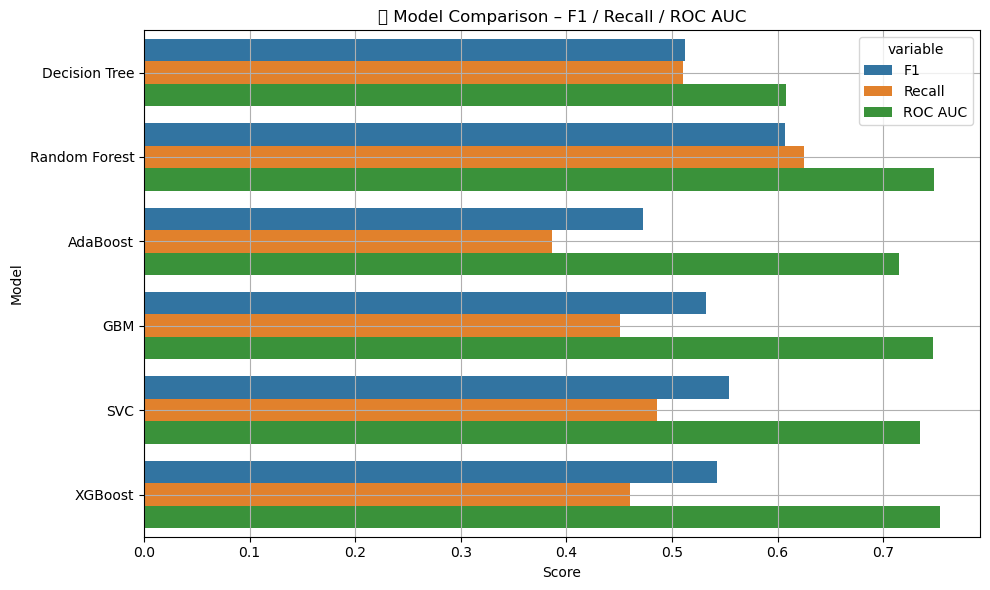

In [24]:
# 📋 Résumé final des scores pour chaque modèle
import seaborn as sns
import matplotlib.pyplot as plt

display(results_df.sort_values(by="F1", ascending=False))

# 🔥 Visualisation des scores F1 / Recall / ROC AUC par modèle
metrics_to_plot = ["F1", "Recall", "ROC AUC"]
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=metrics_to_plot),
            x="value", y="Model", hue="variable")
plt.title("📊 Model Comparison – F1 / Recall / ROC AUC")
plt.xlabel("Score")
plt.ylabel("Model")
plt.grid(True)
plt.tight_layout()
plt.show()